# import packages

In [1]:
from importlib import reload
import src.PATH
reload(src.PATH)

<module 'src.PATH' from '/home/ZwZ/script/HER2_prediction/leukocyte/src/PATH.py'>

In [2]:
import os,sys
from src.PATH import *

In [4]:
from src import utils
from src import leukocyte_cluster
from src import my_metrics

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [13]:
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.core.pylabtools import figsize
from matplotlib.backends.backend_pdf import PdfPages

# read data

In [259]:
DF = utils.read_leukocyte(data_path,False) 

preprocess of data

### cluster ni all

/home/ZwZ/script/HER2_prediction/leukocyte/src/leukocyte_cluster.py:65: RuntimeWarning: invalid value encountered in greater
  row_screen = (np.sum(v_data > threshold1,axis=1) <4) | (np.sum(v_data > threshold2,axis=1) <2)


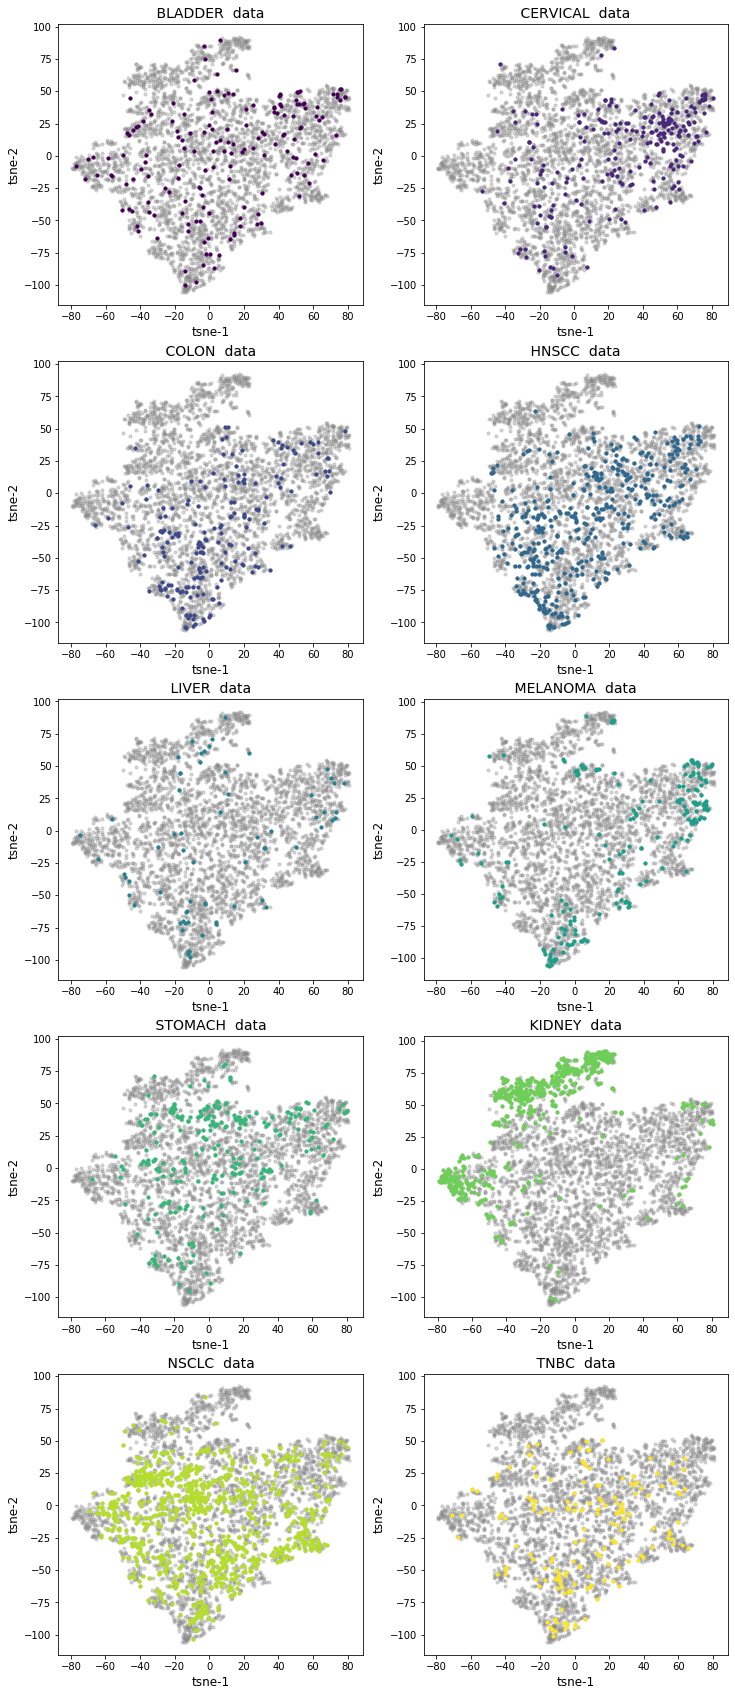

In [12]:
fig = plt.figure(figsize=(12,30))
i = 0
for cancer_type in DF.keys():
    ax = fig.add_subplot(5,2,i+1)
    local_DF,statistics = leukocyte_cluster.statistics_preprocess(DF[cancer_type],False)
    leukocyte_cluster.cluter_in_all_no_label(local_DF,cancer_type,ax=ax,**{'color':cm.viridis(i/9)})
    i += 1

this workes !    
save to pdf  

In [14]:
pdf = PdfPages('test.pdf')
pdf.savefig(fig)
pdf.close()

### legend of stack barplot

In [358]:
local_DF,_ = leukocyte_cluster.statistics_preprocess(DF,False)
all_data =local_DF.iloc[:,1:].values
ALL1 = pd.read_csv(os.path.join(report_path,'ALL_&_label','cluster_labelALL1.csv'),index_col=0)

In [355]:
def sort_data_by_label(n_data,direct_label=None):
    """
    sort data for heatmap and stack-bar plot
    """

    label = direct_label
    label_df=pd.DataFrame({'x':range(n_data.shape[0]),'label': label}).sort_values('label')
    index=label_df['x']
    n_data = n_data[index]
    return n_data,label

In [360]:
# following old method
# labels,metrics = leukocyte_cluster.cluster3(all_data)
# all_data,label = leukocyte_cluster.sort_data_by_label(all_data,labels,metrics)

sort_data,label = sort_data_by_label(all_data,direct_label=ALL1.km.values)

In [379]:
# %load -s stack_barplot ./src/leukocyte_cluster.py
def stack_barplot(data,labels,cmap=cm.Spectral,**kwarg):
    """
    given the data(sorted)  with label,and Z, plot the stacked bar-plot
    """
    print('this will take several minutes')
    pdf = PdfPages('test.pdf')

    label_num = np.bincount(labels)
    
    figsize = (45,15) if data.shape[0] > 2000 else (12,5)
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_axes([0,0,0.8,0.7]) 
    ax2 = fig.add_axes([0,0.7-0.01,0.8,0.05])   # left,bottom,width,height
#     ax3 = fig.add_axes([1,0,0.3,0.7])       # left,bottom,width,height
    
    N = np.arange(data.shape[0])
    
    LEFT = 0
    for num in label_num:
        ax2.barh(0,num,left=LEFT)
        ax2.set_xlim(0,data.shape[0]-1)
        ax2.axis('off')
        LEFT += num
    
#     ax3.axis('off')
#     tree = dendrogram(Z,p=15,truncate_mode='level',no_labels=True,above_threshold_color='black',color_threshold=0.1,ax=ax3)
    if isinstance(cmap,type(cm.Spectral)):
        colour = cmap(0/data.shape[1])
    elif isinstance(cmap,np.ndarray):
        colour = cmap[0]
    ax.bar(N,height=data[:,0],color=colour,**kwarg)
    for i in range(data.shape[1]):
        if isinstance(cmap,type(cm.Spectral)):
            colour = cmap(i/data.shape[1])
        elif isinstance(cmap,np.ndarray):
            colour = cmap[i]
        ax.bar(N,height=data[:,i],bottom=data[:,:i].sum(axis=1),color=colour,width=1,label=cell_label[i],**kwarg)
        ax.set_xlim(0,data.shape[0])
        ax.axis('off')
    fig.legend(bbox_to_anchor=(0.81,0.7),loc='upper left',fontsize=20)
    fig.show()
    pdf.savefig()
    pdf.close()

color of immune cell

In [367]:
cell_label=list(local_DF.columns)[1:]                                       # left cell
color_ls=colors[colors.cell.apply(lambda x : x in cell_label)].HEX.values   # select from all

this will take several minutes


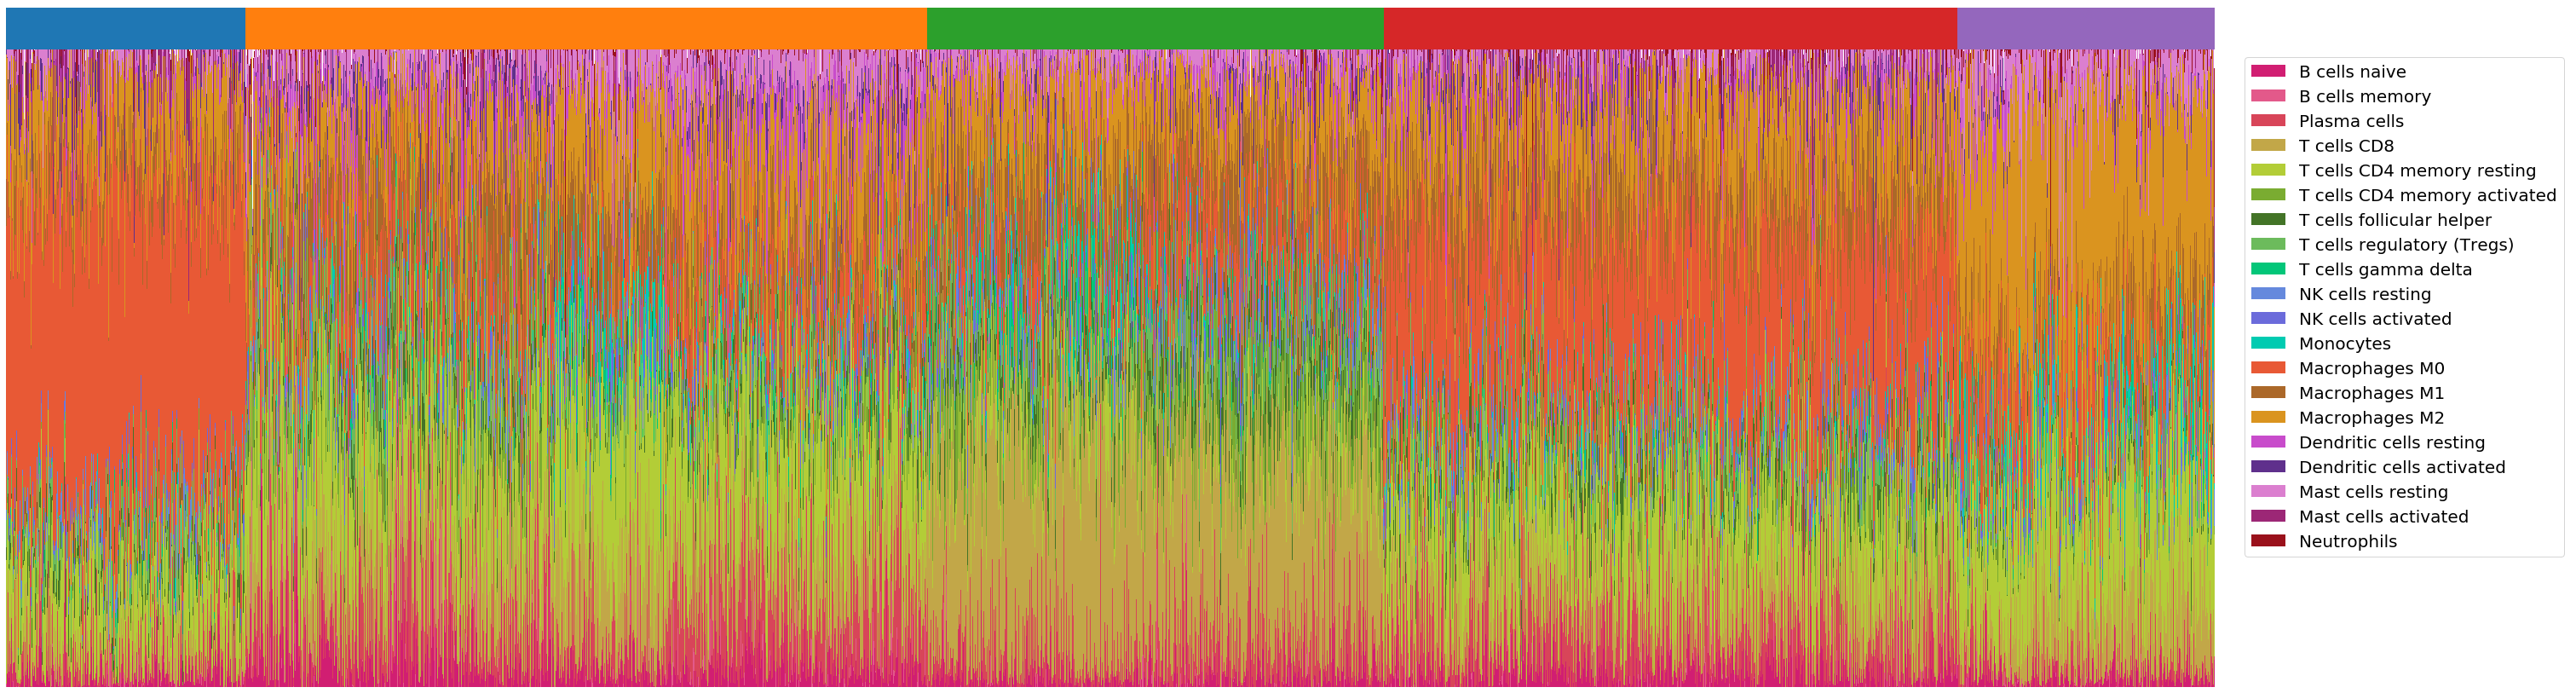

In [380]:
stack_barplot(sort_data,label,cmap=color_ls)

# make a label DF

goal : merging cluster label, cancer type and t_sne axis together

In [18]:
cancer_types = list(DF.keys())
for cancer_type in cancer_types:
    # DF is read above
    DF[cancer_type].loc[:,'cancer_type'] = np.array([cancer_type]*DF[cancer_type].shape[0])

In [25]:
DF0=DF[cancer_types[0]]                    # take the first DF as the base
for cancer_type in cancer_types[1:]:
    DF0 = DF0.append(DF[cancer_type])      # concatenate DF by append`

In [28]:
all_tsne = pd.read_csv(os.path.join(tsne_path,'ALL_tsne_p30.csv'))

In [39]:
label_df = pd.read_csv(os.path.join(report_path,'ALL_&_label','cluster_labelALL1.csv'),index_col=0)

save to csv

In [53]:
merged_df=all_tsne.merge(label_df,left_on=['id'],right_on=['id'],how='inner')

merged_df = merged_df.merge(DF0[['id','cancer_type']],left_on=['id'],right_on=['id'],how='inner')

merged_df.to_csv(os.path.join(tsne_path,'ALL_tsne_p30.csv'),index=False)

# summarize the partition of each cancer type in 5 groups

In [55]:
from IPython.display import HTML

In [92]:
tab_cancertype = '         {} '*len(cancer_types)

In [97]:
print('———————————————————'*9)
print(tab_cancertype.format(*cancer_types))
print('———————————————————'*9)
for i in range(1,6):
    print('cluster',i)
print('———————————————————'*9)

———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
         BLADDER          CERVICAL          COLON          HNSCC          LIVER          MELANOMA          STOMACH          KIDNEY          NSCLC          TNBC 
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————


In [158]:
clust = ['cluster'+str(i) for i in range(1,6)]
statistics = pd.DataFrame(clust,columns=['km_label']).set_index('km_label')

In [159]:
for cancer_type in cancer_types:
    statistics.loc[:,cancer_type] = [np.sum((merged_df.cancer_type == cancer_type) & (merged_df.km ==i)) for i in range(5)]
count = statistics.values
partition = count / np.sum(count,axis=0)
statistics=statistics.astype(str)  # for the convinent of add proportion info

In [160]:
for cancer_type in cancer_types:
    total_num = np.sum(merged_df.cancer_type == cancer_type)
    
    statistics.loc[:,cancer_type] = statistics.loc[:,cancer_type].apply(
        lambda x: x + '({:.2f} %)'.format(int(x)/total_num *100)
    )

In [184]:
row_sum=pd.DataFrame(
    np.array(['{}({:.2f}%)'.format(i,j) for i,j in zip(count.sum(axis=0),(100*count.sum(axis=0)/count.sum()))]).reshape(1,10),
    columns=statistics.columns
)

In [186]:
statistics=statistics.append(row_sum)

In [192]:
col_count= np.array(list(count.sum(axis=1))+[count.sum()])
col_part = col_count/count.sum()*100

In [193]:
col_sum = ['{} ({:.2f}%)'.format(col_count[i],col_part[i]) for i in range(6)]

In [195]:
statistics.insert(10,'total',value=col_sum)

In [203]:
statistics.index = list(statistics.index)[:5]+['sum']

In [205]:
statistics.to_csv(os.path.join(report_path,'cluster_ratio_statistics.csv'),index=True)